In [18]:
%matplotlib inline
import re
import os
import zipfile
from zlib import crc32

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from requests import get as req_get

In [2]:
# get dataset from statlib
if not os.path.exists('data'):
    os.mkdir('data')
if not os.path.exists('data/cadata.txt') and not os.path.exists('data/housing.csv'):
    if not os.path.exists('data/data.zip'):
        load_data = req_get('http://lib.stat.cmu.edu/datasets/houses.zip')
        with open('data/data.zip', 'wb') as f:
            f.write(load_data.content)
    zip_data = zipfile.ZipFile('data/data.zip', 'r')
    zip_data.extractall('data/')
    os.remove('data/data.zip')

In [3]:
# read origin text file then form a formal csv file, or read csv file preprocessed 
if os.path.exists('data/housing.csv'):
    df = pd.read_csv('data/housing.csv')
else:
    with open('data/cadata.txt', 'r', encoding='Windows-1252') as fe:
        fe.seek(1575)
        data = fe.read()
    data = data.splitlines()
    for index, sub_data in enumerate(data):
        data[index] = sub_data.strip()
        data[index] = list(filter(lambda x: x != '', re.split('\s|\s\s', data[index])))
        data[index] = list(map(lambda x: float(x), data[index]))
    df = pd.DataFrame(data, columns=['median house value', 'median income', 'housing median age', 'total rooms', 'total bedrooms', 'population', 'households', 'latitude', 'longitude'])
    df.to_csv('data/housing.csv', index=False)
    os.remove('data/cadata.txt')

df.head()

,median house value,median income,housing median age,total rooms,total bedrooms,population,households,latitude,longitude
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25


In [4]:
# read dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median house value  20640 non-null  float64
 1   median income       20640 non-null  float64
 2   housing median age  20640 non-null  float64
 3   total rooms         20640 non-null  float64
 4   total bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.describe()

,median house value,median income,housing median age,total rooms,total bedrooms,population,households,latitude,longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680,35.631861,-119.569704
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753,2.135952,2.003532
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000,33.930000,-121.800000
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000,34.260000,-118.490000
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000,37.710000,-118.010000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000


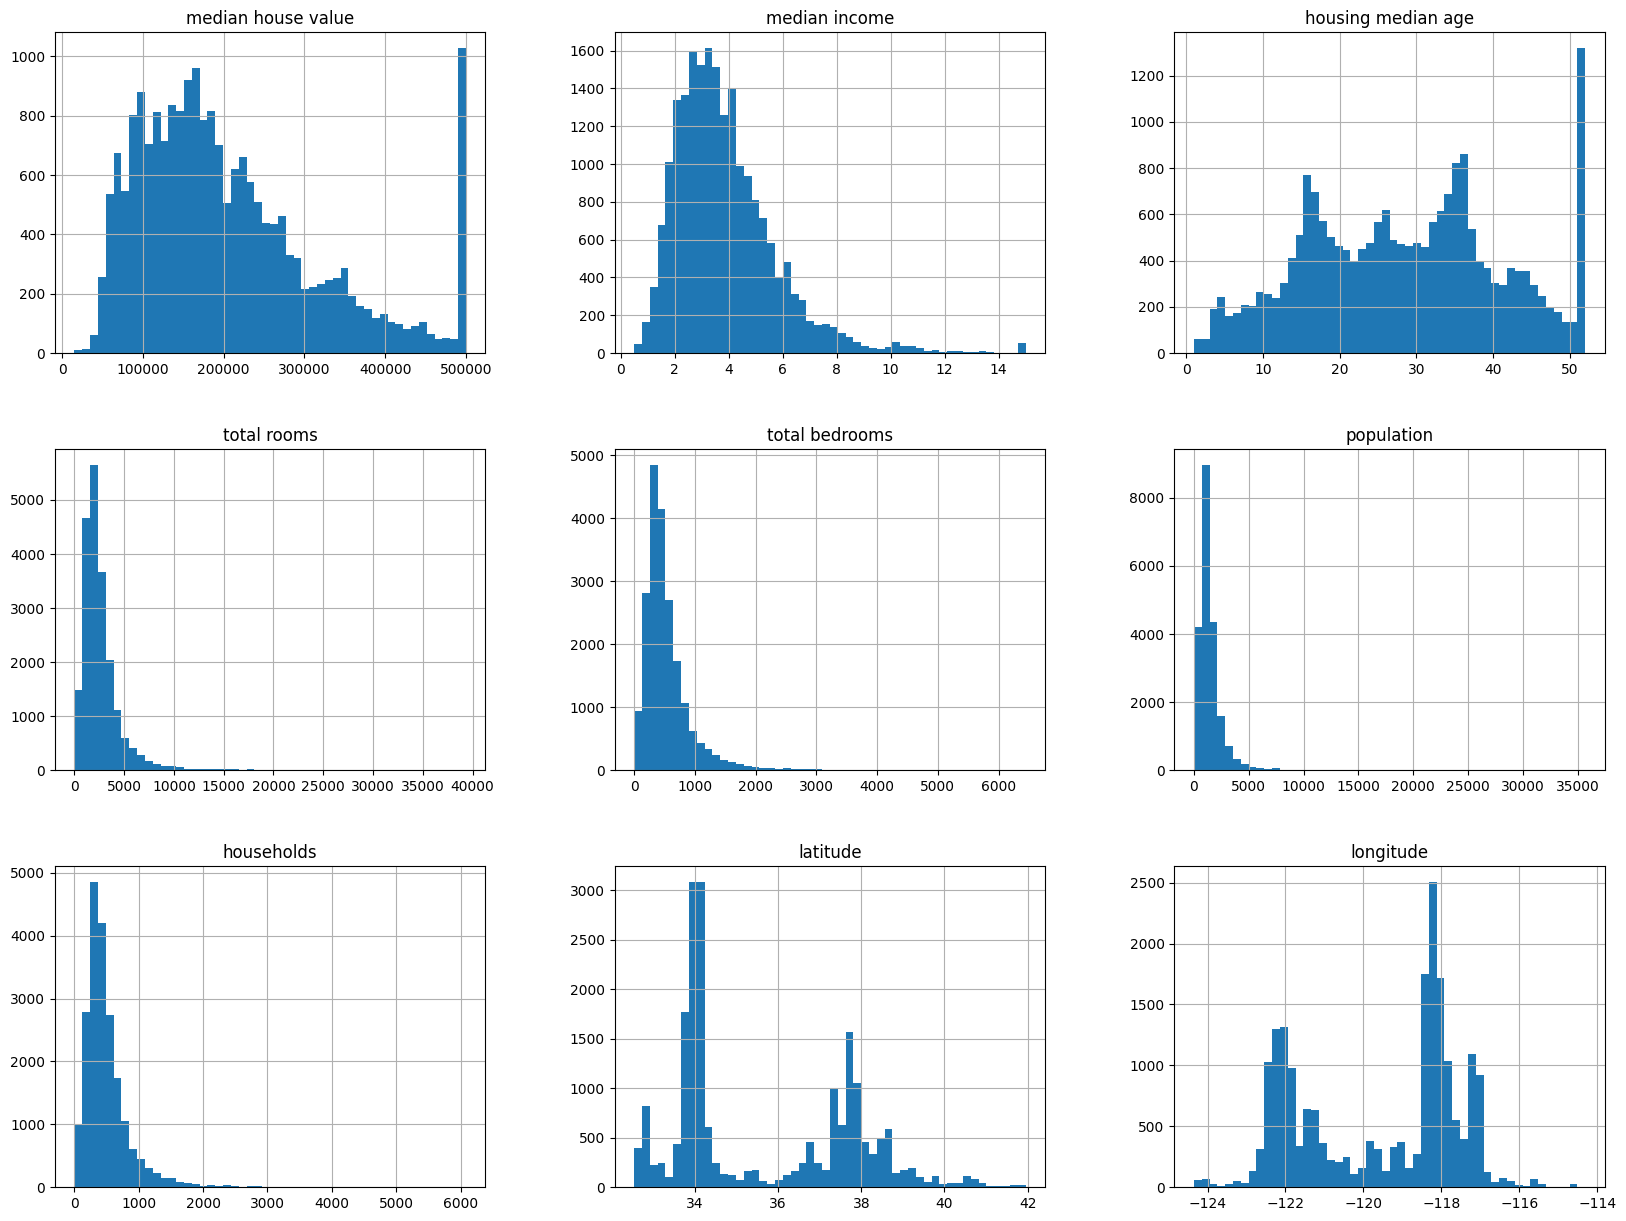

In [6]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

In [7]:
# split dataset by trainset and testset
# 'true' random sampling
df["id"] = df["longitude"] * 1000 + df["latitude"]

np.random.seed(42)
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32 # crc-32 here used as hash func

def split_train_test(dataset, test_ratio, id_column):
    # shuffled_indices = np.random.permutation(len(dataset))
    # test_set_size = int(len(dataset) * test_radio)
    # test_indices = shuffled_indices[:test_set_size]
    # train_indices = shuffled_indices[test_set_size:]
    # return dataset.iloc[train_indices], dataset.iloc[test_indices]
    ids = dataset[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return dataset[~in_test_set], dataset[in_test_set]

train_set, test_set = split_train_test(df, 0.2, "id") # instead of train_test_split in scikit-learn
# train_set, test_set = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=42)
train_set

,median house value,median income,housing median age,total rooms,total bedrooms,population,households,latitude,longitude,id
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23,-122192.12
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22,-122182.14
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24,-122202.15
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25,-122212.15
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25,-122212.15
...,...,...,...,...,...,...,...,...,...,...
20635,78100.0,1.5603,25.0,1665.0,374.0,845.0,330.0,39.48,-121.09,-121050.52
20636,77100.0,2.5568,18.0,697.0,150.0,356.0,114.0,39.49,-121.21,-121170.51
20637,92300.0,1.7000,17.0,2254.0,485.0,1007.0,433.0,39.43,-121.22,-121180.57
20638,84700.0,1.8672,18.0,1860.0,409.0,741.0,349.0,39.43,-121.32,-121280.57


<Axes: >

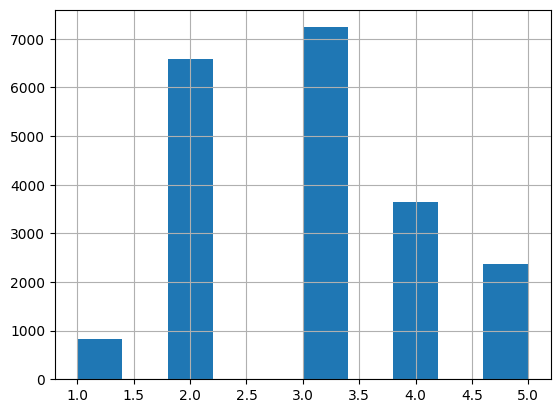

In [8]:
# stratified sampling
df["income cat"] = pd.cut(
    df["median income"],
    bins=[0., 1.5, 3., 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)
df["income cat"].hist()

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
strat_test_set["income cat"].value_counts() / len(strat_test_set)

income cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [10]:
# restore origin dataset
for _set in (strat_train_set, strat_test_set):
    _set.drop("income cat", axis=1, inplace=True)

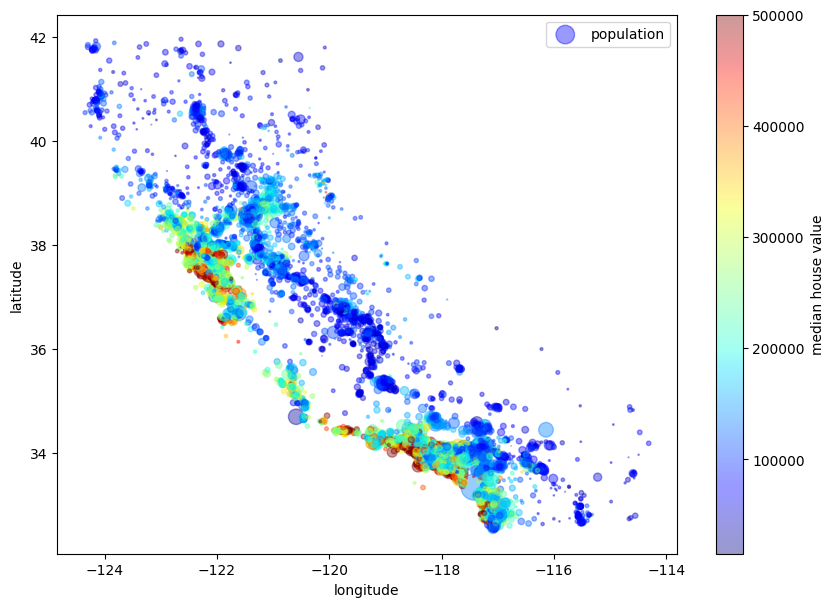

In [11]:
# copy strat train set then check the location of it
housing = strat_train_set.copy()
housing.plot(
    kind="scatter", x="longitude", y="latitude", alpha=0.4, c="median house value", cmap=plt.get_cmap("jet"), colorbar=True,
    s=housing["population"] / 100, label="population", figsize=(10, 7)
)
plt.legend()

In [14]:
# measuring correlation
corr_matrix = housing.drop("id", axis=1).corr()
corr_matrix

,median house value,median income,housing median age,total rooms,total bedrooms,population,households,latitude,longitude
median house value,1.000000,0.687151,0.114146,0.135140,0.048586,-0.026882,0.064590,-0.142673,-0.047466
median income,0.687151,1.000000,-0.111315,0.200133,-0.010508,0.002421,0.010869,-0.075146,-0.019615
housing median age,0.114146,-0.111315,1.000000,-0.364535,-0.324880,-0.298737,-0.306473,0.005737,-0.105823
total rooms,0.135140,0.200133,-0.364535,1.000000,0.928825,0.855103,0.918396,-0.039245,0.048909
total bedrooms,0.048586,-0.010508,-0.324880,0.928825,1.000000,0.876620,0.980290,-0.071836,0.075343
population,-0.026882,0.002421,-0.298737,0.855103,0.876620,1.000000,0.904639,-0.115290,0.108071
households,0.064590,0.010869,-0.306473,0.918396,0.980290,0.904639,1.000000,-0.077765,0.063146
latitude,-0.142673,-0.075146,0.005737,-0.039245,-0.071836,-0.115290,-0.077765,1.000000,-0.924478
longitude,-0.047466,-0.019615,-0.105823,0.048909,0.075343,0.108071,0.063146,-0.924478,1.000000


array([[<Axes: xlabel='median house value', ylabel='median house value'>,
        <Axes: xlabel='median income', ylabel='median house value'>,
        <Axes: xlabel='total rooms', ylabel='median house value'>,
        <Axes: xlabel='housing median age', ylabel='median house value'>],
       [<Axes: xlabel='median house value', ylabel='median income'>,
        <Axes: xlabel='median income', ylabel='median income'>,
        <Axes: xlabel='total rooms', ylabel='median income'>,
        <Axes: xlabel='housing median age', ylabel='median income'>],
       [<Axes: xlabel='median house value', ylabel='total rooms'>,
        <Axes: xlabel='median income', ylabel='total rooms'>,
        <Axes: xlabel='total rooms', ylabel='total rooms'>,
        <Axes: xlabel='housing median age', ylabel='total rooms'>],
       [<Axes: xlabel='median house value', ylabel='housing median age'>,
        <Axes: xlabel='median income', ylabel='housing median age'>,
        <Axes: xlabel='total rooms', ylabel='housi

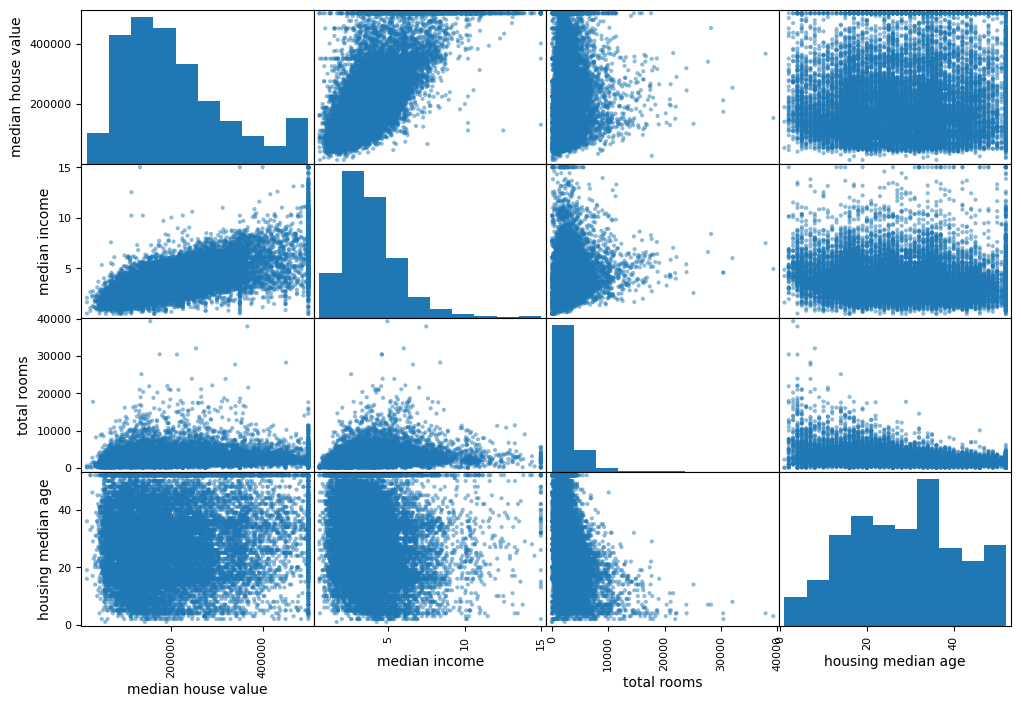

In [15]:
# print scatter to find the correlation of following attributes
attributes = [ 'median house value', 'median income', 'total rooms', 'housing median age', ]
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))

<Axes: xlabel='median income', ylabel='median house value'>

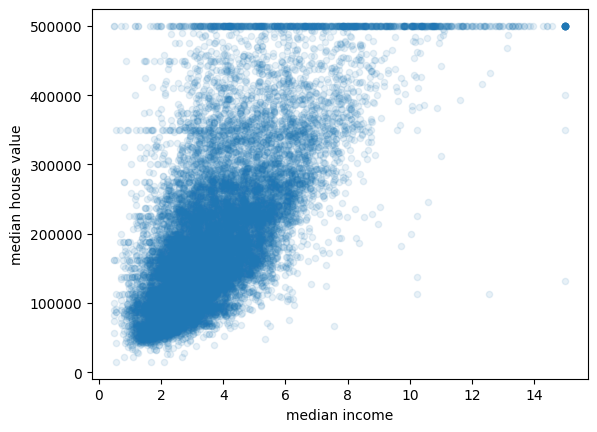

In [16]:
housing.plot(kind="scatter", x="median income", y="median house value", alpha=0.1)

In [17]:
# add some combined attributes then find correlation between them and house value
housing["rooms per household"] = housing["total rooms"] / housing["households"]
housing["bedrooms per room"] = housing["total bedrooms"] / housing["total rooms"]
housing["population per household"] = housing["population"] / housing["households"]

corr_matrix = housing.drop("id", axis=1).corr()
corr_matrix["median house value"].sort_values(ascending=False)

median house value          1.000000
median income               0.687151
rooms per household         0.146255
total rooms                 0.135140
housing median age          0.114146
households                  0.064590
total bedrooms              0.048586
population per household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms per room          -0.259934
Name: median house value, dtype: float64

In [19]:
# now we prepare the data for trainning
# fill null with median value
housing = strat_train_set.drop("median house value", axis=1)
housing_labels = strat_train_set["median house value"].copy()
imputer = SimpleImputer(strategy="median")
imputer.fit(housing)
X = imputer.transform(housing)
# above two statements can be instead of following
# X = imputer.fit_transform(housing)